<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to introduce the concept of Bayesian Optimization using Gaussian Processes. 

<div class="alert alert-info">

**Note:** This material is primarily from [Christopher De Sa's class lecture notes from Cornell](https://www.cs.cornell.edu/courses/cs4787/2019sp/notes/lecture16.pdf) and some examples borrowed from Martin Krasser's blog on [this topic](http://krasserm.github.io/2018/03/21/bayesian-optimization/).

</div>

### Optimization problem

We want to optimize a function $f: \mathcal{X} \rightarrow \mathbb{R}$, defined over some set ${\bf X}$. We have done this a lot in the past using methods such as *Gradient Descent* and *Newton's Method* and *Quadratic Optimization*. However, in each of these methods, we assumed that $f(\cdot)$ is inexpensive to compute and we can, either analytically or numerically, calculate the gradient of $f(\cdot)$.

What if $f(\cdot)$ is expensive to compute. 

<img src='./images/manufacturing.gif'/>



> Example: Consider an example of **advanced manufacturing**. Scientists and engineers are trying to figure the optimal manufacturing process to produce a material with some desirable properties. The process is parameterized by several parameters (say 10). Each parameter would define the initial conditions (temperature, etc.), or material properties, environmental conditions (shape, size of equipment, etc.) and others. Trying out combinations in a wet-lab or actual environment is infeasible. Instead, the scientists work with the next best thing, a computer simulation of the process. Each run of the simulation takes, as input, a particular combination of the 10 parameters. At the end of the simulation, the property (or properties) of the final material is measured. A brute-force approach to figure out the optimal parameter combination would be to consider all possible combinations and find the combination that gives the best property value. Here we will assume that the lower value of the output property is better. However, the brute-force approach is also infeasible because each simulation is costly and it is not clear how fine the mesh in the parameter space would have to be, to guarantee optimal parameter setting.

<img src='./images/2dsurface.jpg'/>

One can also consider the above example as an optimization problem, in which evaluating the function $f(\cdot)$ on a 10 length vector (one combination of the parameters) requires running the simulation and then measuring some desired property of the final state. This property is the function value. Clearly, this is an expensive process and not something that can be done many times to create a 10-D surface, as shown above.

> Another scenario would be the determination of optimal hyper-parameters for a complex machine learning model, e.g., number of hidden layers, number of units per layer, etc., in a deep neural network. Given a training data set, we are interested in finding the optimal settings for the network configuration parameters which would result in lowest training error. However, evaluating the objective function, $f(\cdot)$, would entail training the entire neural network, which, as we all know, is an expensive task.

### Approximating the objective function $f(\cdot)$
General idea behind Bayesian optimization:
- Model $f(\cdot)$ as a stochastic process
- Assuming that we have evaluated $f(\cdot)$ on set of inputs, i.e., we have observed $f({\bf x}_1),f({\bf x}_2),\ldots f({\bf x}_D)$, the probabilistic model gives us the following condition distribution:
$$
p(f({\bf x})\vert f({\bf x}_1),f({\bf x}_2),\ldots,f({\bf x}_D))
$$
- The conditional distribution is used to choose the next value of ${\bf x}$ at which $f(\cdot)$ needs to be evaluated
- The optimal value of the function values observed so far, gives the current optima

<div class="alert alert-danger">

The key benefit of Bayesian Optimization is that it uses all the information so far, to choose the next point to evaluate. Gradient descent, on the other hand, only uses information from the previous evaluation

</div>

### Key ingredients of Bayesian Optimization
Two major decision need to be made:
1. The prior on $f(\cdot)$, generally referred to as a **surrogate function** - we will use GP for this
2. The function to choose the next point to evaluate, also referred to as the **acquisition function** and denoted as $a()$
   * The acquisition function can be a function of multiple inputs and depends on what function is being used
   * Many of these combine the following three things about a possible sample, ${\bf x}_*$:
     - The predictive mean at ${\bf x}_*$ - $\mu_*$
     - The predictive uncertainity (variance) at ${\bf x}_*$ - $\sigma_*^2$
     - The current best value see so far - $y_{best}$
   * Of course, we already know how to get $\mu_*$ and $\sigma^2_*$ 

Here is a very simple sketch of a Bayesian Optimization procedure:


**Step 1** - (*Warm up*) - evaluate $f(\cdot)$ on an initial sample of ${\bf x}$'s (usually obtained using random sampling), also find the current best function value ($y_{best}$)

**Step 2** - (*Sampling*) - solve an optimization problem to identify the next sample point as:
$$
\underset{{\bf x}_*}{\arg\max} ~~ a(\mu_*,\sigma^2_*,y_{best})
$$
Repeat step 2, until some convergence criteria is met.

### Different types of acquisition functions
- **Probability of improvement**
- **Expected improvement**
- **Lower confidence bound**


### Expected improvement
$$
EI({\bf x}_*) = \mathbb{E}[\max{(f({\bf x}_*)-y_{best},0)}]
$$

In other words, the next sample to evaluate (${\bf x}_*$), would be the sample gives the best expected improvement over the current best (here we are interested in finding the maxima).

For GP based *surrogate*, this can be written as:
$$
EI({\bf x}_*) = \left\{
\begin{array}{cc}
(\mu_* - y_{best} - \xi)\Phi(Z) + {\sigma_*}\phi(Z) & \text{if } \sigma_* > 0\\
0 & \text{if } \sigma_* = 0
\end{array}
\right.
$$
where
$$
Z = \left\{
\begin{array}{cc}
\frac{\mu_* - y_{best} - \xi}{\sigma_*} & \text{if } \sigma_* > 0\\
0 & \text{if } \sigma_* = 0
\end{array}
\right.
$$
and $\Phi$ and $\phi$ are the CDF and PDF of the standard normal distribution.

Let us inspect the two terms in the acquisition function. The first term favors ${\bf x}_*$ such that the predictive mean improves the current optimal value more. The second term favors ${\bf x}_*$ where the predictive variance is higher. These two counteracting terms are referred to as **exploitation** and **exploration** terms.

The parameter $\xi$ determines the amount of exploration, higher values lead to more exploration. 



### Example


In [2]:
%run Utilities.ipynb

In [3]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

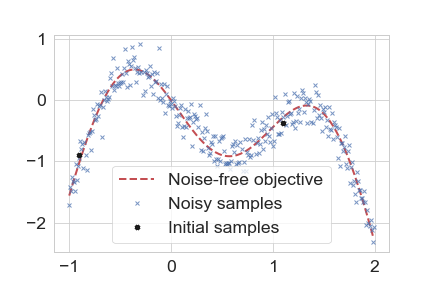

In [23]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'r--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.75, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [35]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
                
    return ei.flatten()

In [41]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [37]:
def min_obj(X):
    # Minimization objective is the negative acquisition function
    return -expected_improvement(X.reshape(-1, dim), X_sample, Y_sample, gpr)

In [38]:
x0 = np.array([1.01665735])
dim = X_sample.shape[1]
min_obj(x0)

array([-0.05816786])

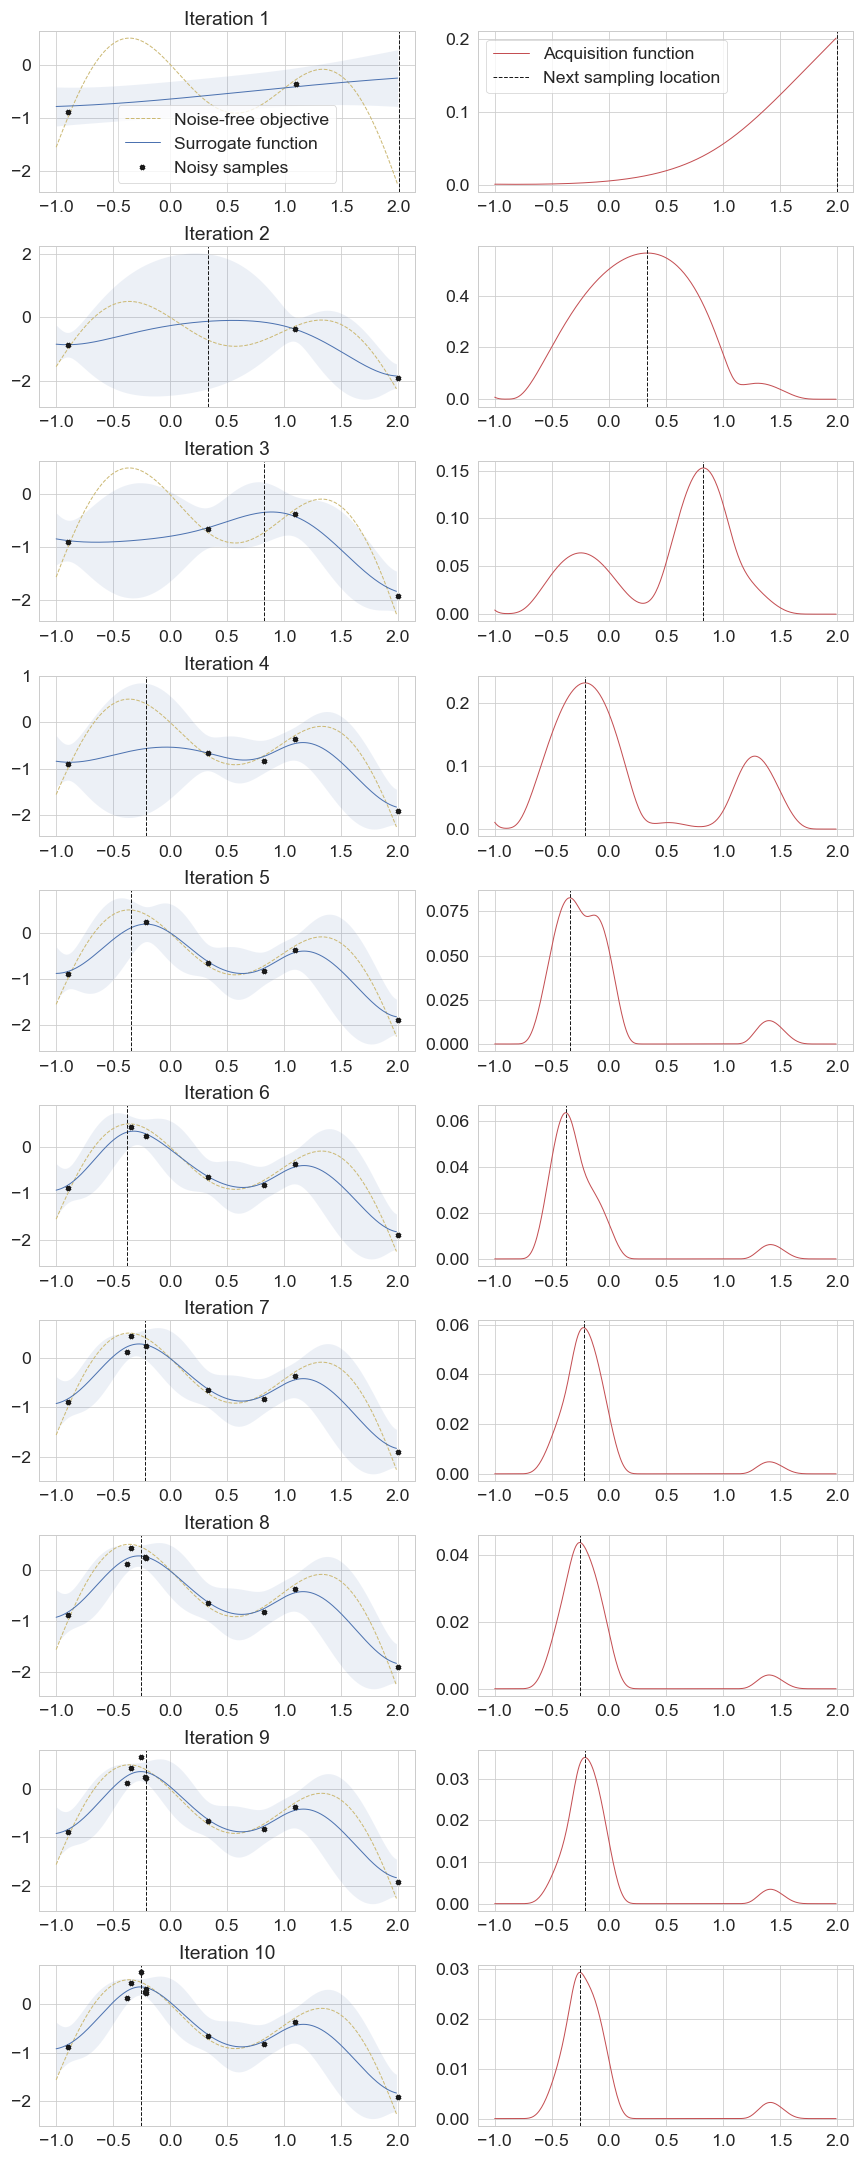

In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Matern kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.2)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
plt.tight_layout()

By the end of the iteration 10, you notice how the mean function for the GP closely approximates the true function. At the same time, the acquisition function shows a peak at the true optima. There is also a second smaller peak (a local optima), which could potentially mislead a gradient based optimizer. That is why we try multiple starting points.

## Analyzing the Bayesian Optimization algorithm

As we observe in the previous example, the Bayesian optimization process involves three for loops:
- The outermost iteration which involves picking a new sample for evaluation
- The second loop that involves a random restart to run the inner optimization (using the `scipy.optimize.minimize` function)
- The innermost loop within the `scipy.optimize.minimize` function used for the gradient descent

Clearly, this looks much more compute intensive than a simple gradient descent approach. See below:

evaluating
evaluating
evaluating
evaluating
evaluating
evaluating
evaluating
evaluating
evaluating
evaluating
evaluating
evaluating
evaluating


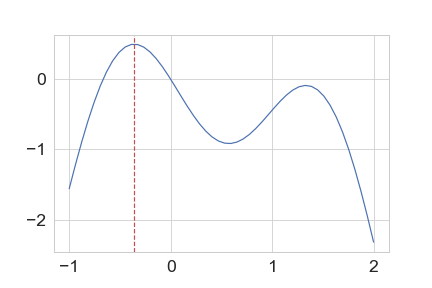

In [133]:
def f1(x):
    print('evaluating')
    return -1*(-np.sin(3*x) - x**2 + 0.7*x)
def grad_f1(x):
    return -1*(-3*np.cos(3*x) - 2*x + 0.7)
x0 =  np.random.uniform(-1,2)
res = minimize(f1, x0=x0, method='L-BFGS-B')
x = np.linspace(-1,2)
y = -1*f1(x)
plt.plot(x,y)
plt.axvline(x=res.x,c='r',linestyle='--')


The difference is the number of function evaluations performed by each method. The gradient descent method, calls the function 13 times. On the other hand, the bayesian optimization method only needs to evaluate the function less than 10 times.

If the cost of the function evaluation is high, the bayesian optimization based strategy can be significantly more efficient.

## Bayesian optimization using `GPyOpt`

In [135]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from numpy.random import multivariate_normal

We will first minimize the following polynomial in the range $[-5,4]$

$$
f(x) = x^4 + 2x^3 - 12x^2 - 2x + 6
$$

In [136]:
def f(x):
    return x**4 + 2*x**3 -12*x**2 - 2*x + 6


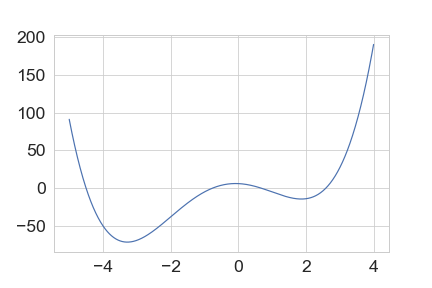

In [140]:
#Plot the function 
x = pd.Series(np.linspace(-5,4,1000))
f_x = pd.Series.apply(x, f)

plt.plot(x, f_x, 'b-')
plt.show()

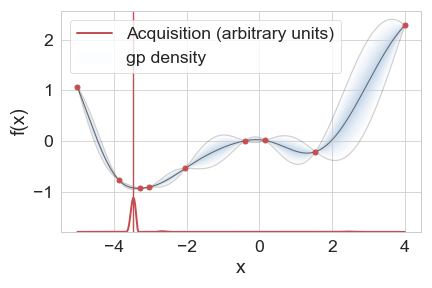

In [147]:
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (-5,4)}]


myBopt_1d = BayesianOptimization(f=f, domain=domain)
myBopt_1d.run_optimization(max_iter=4)
myBopt_1d.plot_acquisition()

To find all the evaluations of $f$, we can use `get_evaluations()`

In [148]:
ins = myBopt_1d.get_evaluations()[1].flatten()
outs = myBopt_1d.get_evaluations()[0].flatten()
evals = pd.DataFrame(ins, outs)
print(evals.sort_index())

                    0
-5.000000   91.000000
-3.870315  -57.580351
-3.274103  -71.370884
-3.040131  -69.602794
-2.031570  -39.199466
-0.403410    4.749124
 0.161581    5.372659
 1.542121  -12.631602
 4.000000  190.000000


Let us now consider a 2 dimensional example.
$$
f(x,y) = (x^2 + y^2) \times (\sin^2(x) - \cos(y))
$$
where $x,y$ is in the range $[0,10] \times [0,10]$

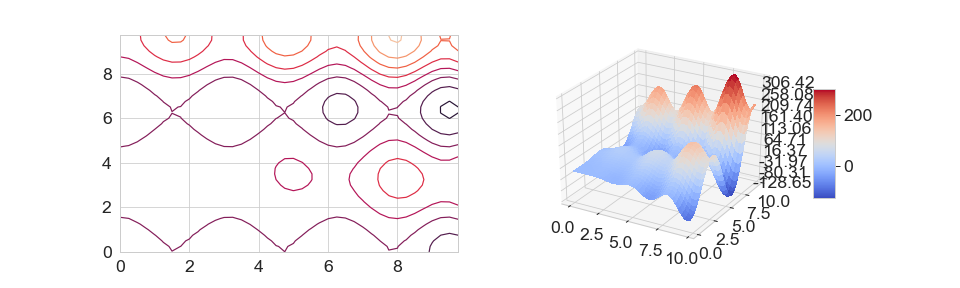

In [149]:
#2-Dimensional Example

def f2(x,y):
    return((x**2 + y**2)*(np.sin(x)**2 - np.cos(y)))


fig = plt.figure(figsize=plt.figaspect(0.3))

# Make data.
X = np.arange(0, 10, 0.25)
Y = np.arange(0, 10, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f2(X,Y)



# First subplot
ax = fig.add_subplot(1, 2, 1)
ax.contour(X,Y,Z)

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)



As you see above, the function has many local extrema. 

Value of (x,y) that minimises the objective:[9.50129542 6.38185538]
Minimum value of the objective: -129.59998831673835


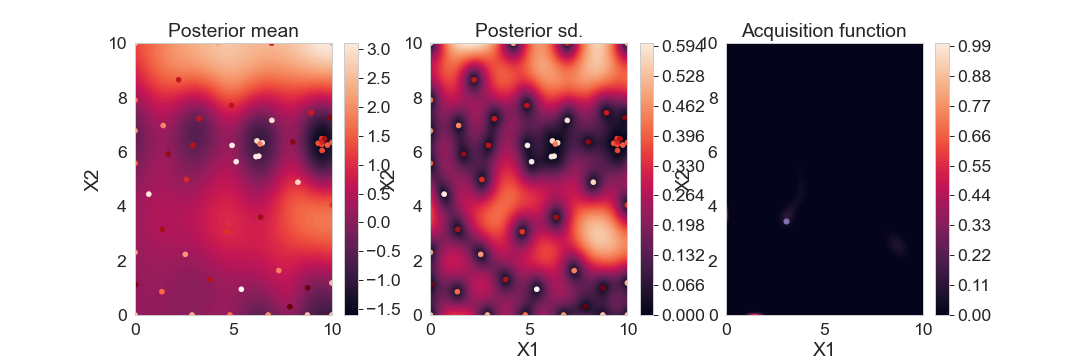

In [150]:
def f2d(x):
    """
    x is a 2 dimensional vector.
    """ 
    x1 = x[:, 0]
    x2 = x[:, 1]
    return((x1**2 + x2**2)*(np.sin(x1)**2 - np.cos(x2)))

bounds2d = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,10)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (0,10)}]
maxiter = 50

myBopt_2d = GPyOpt.methods.BayesianOptimization(f2d, domain=bounds2d)
myBopt_2d.run_optimization(max_iter = maxiter)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_2d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_2d.fx_opt))     
print("="*20)
myBopt_2d.plot_acquisition()

As you can observe, the posterior mean well approximates the true 2d function. The second plot, shows the variance from the GP, which is higher in areas which is relatively unexplored.

### Employing more constraints
Now let us consider a situation where we need to impose more complex constraints on the unknown parameters, beyond just the rectangular domain constraints we have seen so far.

Consider a stochastic version of the above 2d function:

In [180]:
def stochastic_f2d(x):
    #Construct our normal parameters:
    
    mu1,mu2,Sig_diag1,Sig_diag2,Sig_Cross = x[:,0],x[:,1],x[:,2],x[:,3],x[:,4]
    
    mu = np.array([mu1[0], mu2[0]]).flatten()
    Sigma = np.array([[Sig_diag1[0], Sig_Cross[0]], [Sig_Cross[0], Sig_diag2[0]]]) #Cov Matrix must be symmetric so 
    
    sample = multivariate_normal(mu, Sigma, check_valid = 'raise')
    
    #Now run the deterministic objective function
    return(f2(sample[0], sample[1]))

In [181]:
#Now lets set up the Bayesian Optimisation:

bounds = [{'name': 'mu_1', 'type': 'continuous', 'domain': (0,10)},
        {'name': 'mu_2', 'type': 'continuous', 'domain': (0,10)},
         {'name': 'Sig_diag_1', 'type': 'continuous', 'domain': (0,5)},
         {'name': 'Sig_diag_2', 'type': 'continuous', 'domain': (0,5)},
         {'name': 'Sig_Cross', 'type': 'continuous', 'domain': (-5,5)}]

constraints = [{'name': 'constr_1', 'constraint': '-x[:,2]'},
              {'name': 'constr_2', 'constraint': '-x[:,3]'},
              {'name': 'constr_3', 'constraint': '-x[:,2]*x[:,3] + x[:,4]**2'}]

#Above constraints ensure our 2x2 covariance matrix will be symmetric positive definite 
#The expression corresponding to 'constraint' is an inequality that is less than zero - i.e. x[:,2] > 0 etc.

In [183]:
#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = bounds, constraints = constraints) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 10)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(stochastic_f2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [184]:
# Now create BO object
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

In [ ]:
# --- Stop conditions
max_time  = None 
max_iter  = 100
tolerance = 1e-8     # distance between two consecutive observations 
                     # if we're sampling a region in such fine detail then it is likely that we've found the true min.

# Run the optimization                                                  
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=False) 
bo.plot_convergence()

In [ ]:
print(bo.x_opt)
print(bo.fx_opt)

In [ ]:
print(bo.X[0:5]) #The first five evaluations


### Working with mixed types of constraints
We will now try Bayesian Optimization on a function of mixed constraints. We will consider the `alpine` function of the following form:
$$
f(x_1,x_2,\ldots,x_9) = \sum_{i=1}^9 \vert x_i\sin{x_i} + 0.1x_i\vert
$$

In [151]:
func  = GPyOpt.objective_examples.experimentsNd.alpine1(input_dim=9) 


In [175]:
mixed_domain =[{'name': 'vara', 'type': 'continuous', 'domain': (-5,5),'dimensionality': 3},
               {'name': 'varb', 'type': 'discrete', 'domain': (3,8,10),'dimensionality': 2},
               {'name': 'varc', 'type': 'categorical', 'domain': (0,1,2),'dimensionality': 1},
               {'name': 'vard', 'type': 'continuous', 'domain': (-1,2)}]

In [176]:
myBopt = GPyOpt.methods.BayesianOptimization(f=func.f,                     # Objective function       
                                             domain=mixed_domain,          # Box-constraints of the problem
                                             initial_design_numdata = 5,   # Number data initial design
                                             acquisition_type='EI',        # Expected Improvement
                                             exact_feval = True)           # True evaluations, no sample noise

In [177]:
max_iter = 20       ## maximum number of iterations
max_time = 60       ## maximum allowed time
eps      = 1e-6     ## tolerance, max distance between consicutive evaluations.

myBopt.run_optimization(max_iter,eps=0)

In [178]:
np.round(myBopt.X,2)


array([[ 0.81, -4.48,  4.96,  8.  , 10.  ,  0.  ,  1.47],
       [-4.29, -4.35,  3.23,  8.  , 10.  ,  0.  ,  0.3 ],
       [ 0.23,  3.85, -2.69, 10.  ,  3.  ,  2.  ,  0.28],
       [-1.78,  4.86,  2.65,  3.  ,  3.  ,  1.  , -0.31],
       [ 1.49, -3.77,  2.97,  8.  , 10.  ,  0.  ,  0.07],
       [-0.75,  4.52,  0.13,  8.  ,  3.  ,  1.  , -0.14],
       [-3.07,  5.  ,  3.15,  3.  ,  3.  ,  2.  , -1.  ],
       [-4.36,  5.  ,  5.  ,  3.  ,  3.  ,  1.  , -0.23],
       [-2.46,  5.  ,  1.44,  3.  ,  3.  ,  2.  , -1.  ],
       [-1.42,  5.  ,  3.78,  3.  ,  3.  ,  2.  , -1.  ],
       [-3.16,  3.4 ,  2.79,  3.  ,  3.  ,  2.  , -1.  ],
       [-3.74,  1.71,  2.49,  3.  ,  3.  ,  2.  , -1.  ],
       [-2.87,  3.39,  2.83,  3.  ,  3.  ,  2.  ,  0.3 ],
       [-2.88,  3.38,  2.88,  3.  ,  3.  ,  0.  , -0.04],
       [-1.87,  2.54,  2.92,  3.  ,  3.  ,  0.  ,  0.68],
       [-3.72,  3.53,  2.11,  3.  ,  3.  ,  0.  ,  0.76],
       [ 4.92,  2.3 , -5.  , 10.  ,  3.  ,  2.  ,  1.91],
       [-2.73,

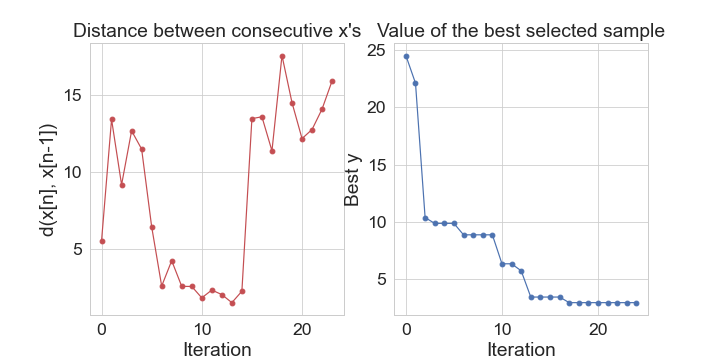

In [179]:
myBopt.plot_convergence()